# Imports

In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from pandas_profiling import ProfileReport 

%matplotlib inline
sns.set()

from math import ceil

# Reading the Data

In [2]:
df = pd.read_csv('donors.csv', header=0, index_col=[0,'CONTROLN'], low_memory=False, 
                 dtype={'TCODE':'str','HPHONE_D':'str','RFA_2F':'str','WEALTH1':'str','WEALTH2':'str','INCOME':'str'})
df.head()

,,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TIMELAG,AVGGIFT,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
,CONTROLN,,,,,,,,,,,,,,,,,,,,,
0,95515,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,,...,4.0,7.741935,0,L,4,E,X,X,X,C
1,148535,2014-01-01,BOA,1,CA,91326,,,1972-02-01,0,,...,18.0,15.666667,0,L,2,G,X,X,X,A
2,15078,2010-01-01,AMH,1,NC,27017,,,NaN,0,,...,12.0,7.481481,1,L,4,E,X,X,X,C
3,172556,2007-01-01,BRY,0,CA,95953,,,1948-01-01,0,,...,9.0,6.812500,1,L,4,E,X,X,X,C
4,7112,2006-01-01,,0,FL,33176,,,1940-01-01,0,X,...,14.0,6.864865,1,L,2,F,X,X,X,A


# Initial Analysis

In [3]:
# Checking for duplicates:
df.duplicated().sum()

0

In [4]:
# check df data types:
df.dtypes

ODATEDW     object
OSOURCE     object
TCODE       object
STATE       object
ZIP         object
             ...  
RFA_2A      object
MDMAUD_R    object
MDMAUD_F    object
MDMAUD_A    object
GEOCODE2    object
Length: 474, dtype: object

In [5]:
# replace "" by nans:
df.replace("", np.nan, inplace=True)

In [6]:
# sorted count of missing values:
df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending=False)

RDATE_5     95403
RAMNT_5     95403
RDATE_3     95170
RAMNT_3     95170
RDATE_4     95131
            ...  
MSA           132
ADI           132
DMA           132
GEOCODE2      132
FISTDATE        2
Length: 92, dtype: int64

In [7]:
# checking descriptive statistics:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
NUMCHLD,12386.0,1.527773,0.806861,1.000000,1.000000,1.000000,2.000000,7.0
HIT,95412.0,3.321438,9.306899,0.000000,0.000000,0.000000,3.000000,241.0
MBCRAFT,42558.0,0.152075,0.470023,0.000000,0.000000,0.000000,0.000000,6.0
MBGARDEN,42558.0,0.059166,0.262078,0.000000,0.000000,0.000000,0.000000,4.0
MBBOOKS,42558.0,1.116382,1.669967,0.000000,0.000000,0.000000,2.000000,9.0
...,...,...,...,...,...,...,...,...
MINRAMNT,95412.0,7.933656,8.784231,0.000000,3.000000,5.000000,10.000000,1000.0
MAXRAMNT,95412.0,19.999790,25.067746,5.000000,14.000000,17.000000,23.000000,5000.0
LASTGIFT,95412.0,17.313127,13.956630,0.000000,10.000000,15.000000,20.000000,1000.0
TIMELAG,85439.0,8.093739,8.213242,0.000000,4.000000,6.000000,11.000000,1088.0


### Feature Engineering

In [8]:
df["ODATEDW"] = df["ODATEDW"].apply(lambda x: x[:7])

In [9]:
df['DOB'] = df['DOB'].apply(lambda x: int(str(x)[:4]) if (str(x)!='nan') else None)
df['DOB'] = 2020 - df['DOB']
df.rename(columns={'DOB':'Age'},inplace=True)

## Missing Values

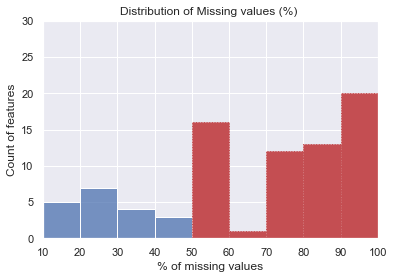

In [10]:
# Plotting the distribution of missing values(greater than 10%)
ax = sns.histplot(df.isnull().mean()*100, bins='auto')
ax.set_title('Distribution of Missing values (%) ')
ax.set(xlabel='% of missing values', ylabel='Count of features',xlim=(10,100),ylim=(0,30))
# Colloring red the bars that represent the count of features with % of missing values >= 50% :
for i in range(5,10):
    ax.patches[i].set_color('r')
    ax.patches[i].set_linestyle(':')
plt.show(ax)

### Removing the features that have missing values

We are removing all the columns that have more than 50% of Missing Values

### Nota: Ver as ADATES

In [11]:
cols = df.columns[df.isnull().mean() > 0.5]

display(pd.DataFrame(df[cols].isnull().mean()*100, columns=['% Missing Values']).sort_values(by='% Missing Values',ascending=False))

df = df.drop(cols, axis=1)

,% Missing Values
RDATE_5,99.990567
RAMNT_5,99.990567
RAMNT_3,99.746363
RDATE_3,99.746363
RDATE_4,99.705488
...,...
PUBPHOTO,55.395548
PUBCULIN,55.395548
MBCRAFT,55.395548
PUBHLTH,55.395548


#### Metric and Non-Metric Variables:

In [12]:
def update_metric_feat(df):
    metric_features = df.select_dtypes(include=np.number).columns
    non_metric_features = df.select_dtypes(exclude=np.number).columns
    return metric_features.tolist(),non_metric_features.tolist()

metric_features = update_metric_feat(df)[0]
non_metric_features = update_metric_feat(df)[1]

## Outliers

#### Box Plots:

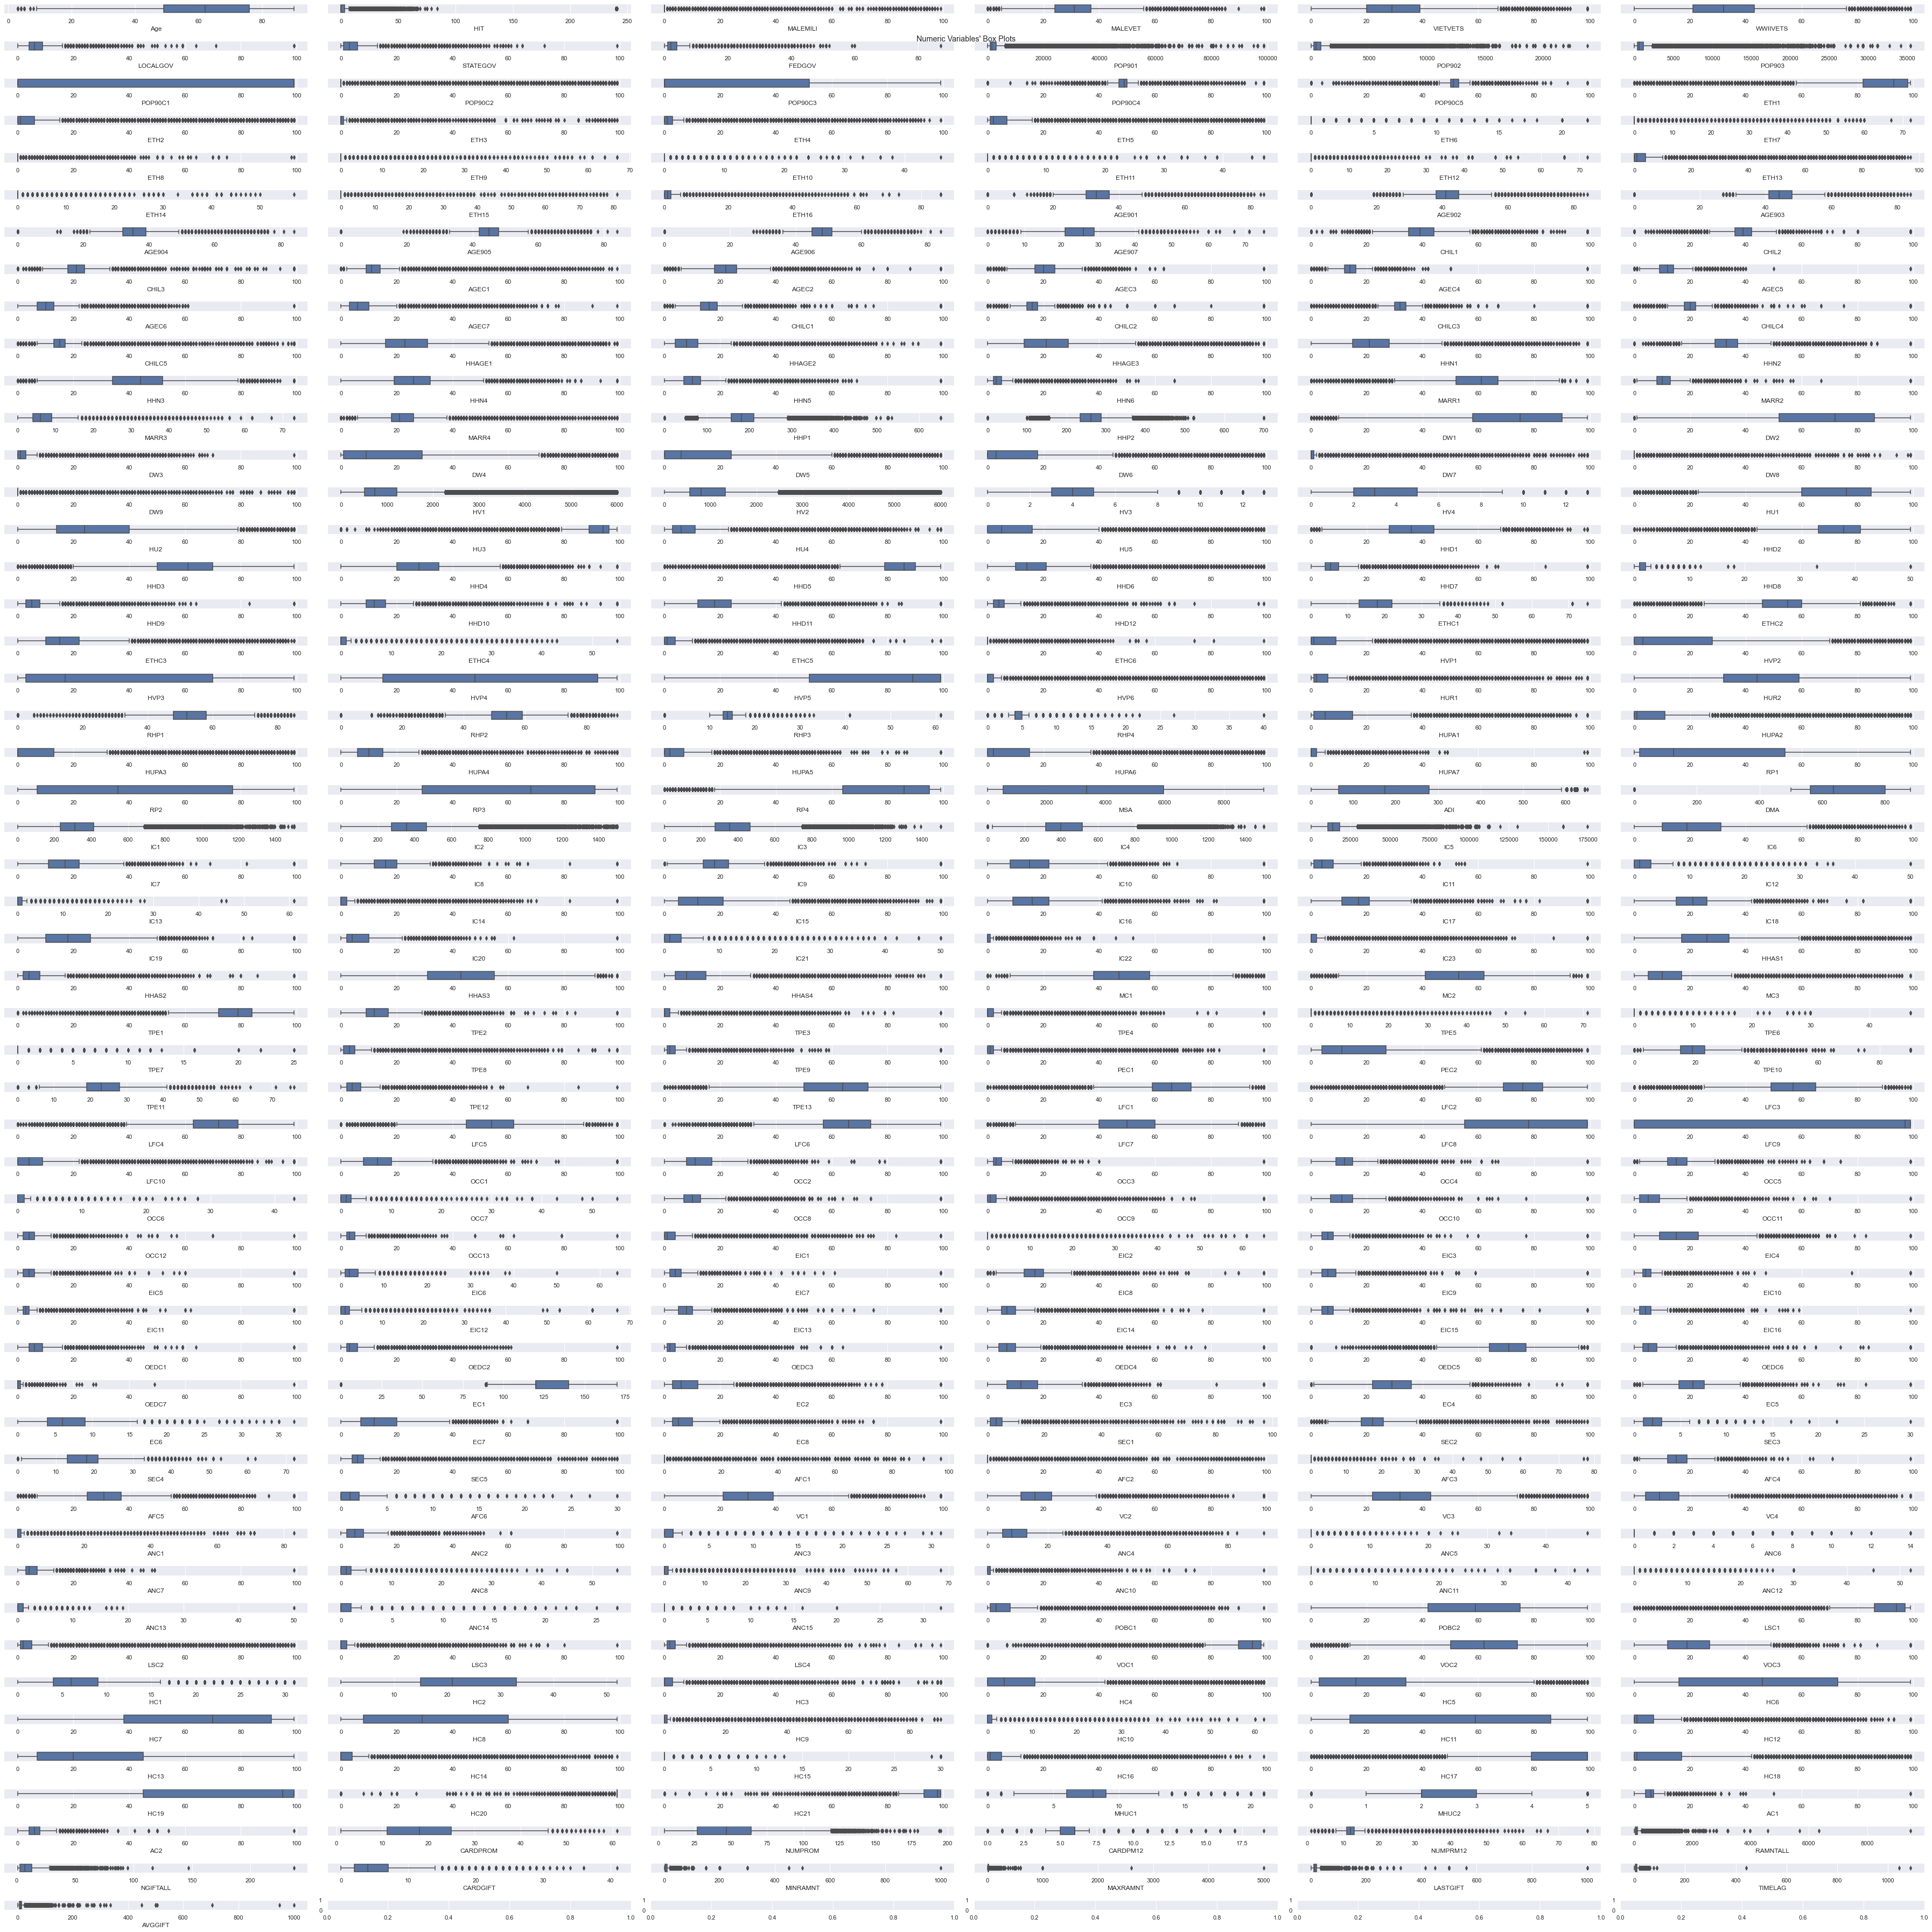

In [13]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(52, ceil(len(metric_features) / 52), figsize=(50, 50), squeeze=True)

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), metric_features): 
    sns.boxplot(x=df[feat], ax=ax)
#     ax.set_title(feat, y=-0.21)

# Adjusting my subplots:
fig.tight_layout()

# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"
plt.suptitle(title)

plt.show()

## Fill missing values (Data imputation)

Filling the Categorical Variables with the mode and the Numeric Variables with the Median

In [14]:
for column in df[non_metric_features]:
    df[column] = df[column].fillna(df[column].mode()[0])

for column in df[metric_features]:
    df[column] = df[column].fillna(df[column].median())

In [15]:
df.isnull().sum()

ODATEDW     0
OSOURCE     0
TCODE       0
STATE       0
ZIP         0
           ..
RFA_2A      0
MDMAUD_R    0
MDMAUD_F    0
MDMAUD_A    0
GEOCODE2    0
Length: 412, dtype: int64

# Metric Features

## Low Variance

Removing variables with low Variance

Done on a scaled data using MinMax Scaler

If the variance is too low, it means that it does not change much and hence it can be ignored


#### -> Function that plots Histograms of a set of variables:

In [16]:
def histograms(df,features, bins='auto',figsize=(15, 8)):
    # Put this Variables' Histograms in one figure
    sns.set()

    # Prepare figure. Create individual axes where each histogram will be placed
    fig, axes = plt.subplots(ceil(len(features) / 4),4, figsize=figsize)

    # Plot data
    # Iterate across axes objects and associate each histogram:
    for ax, feat in zip(axes.flatten(), features):
        ax.hist(df[feat], bins=bins)
        ax.set_title(feat, y=-0.17)

    # Layout
    # Add a centered title to the figure:
    title = "Variables' Histograms"
    plt.suptitle(title)
    plt.show()

In [17]:
# Scalling our data:
scaler = MinMaxScaler()
# transform data:
scaled = scaler.fit_transform(df[metric_features])
scaled = pd.DataFrame(scaled,columns = metric_features)

The following are redundant variables because of their low variance:
 ['ETH8', 'ETH10', 'ETH11', 'ETH12', 'ETH14', 'HHD8', 'ETHC6', 'RHP4', 'IC22', 'TPE6', 'TPE7', 'OCC3', 'OCC6', 'OEDC7', 'AFC3', 'ANC1', 'ANC5', 'ANC10', 'ANC11', 'ANC12', 'ANC13', 'ANC15', 'HC15', 'AC1', 'RAMNTALL', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'TIMELAG', 'AVGGIFT']


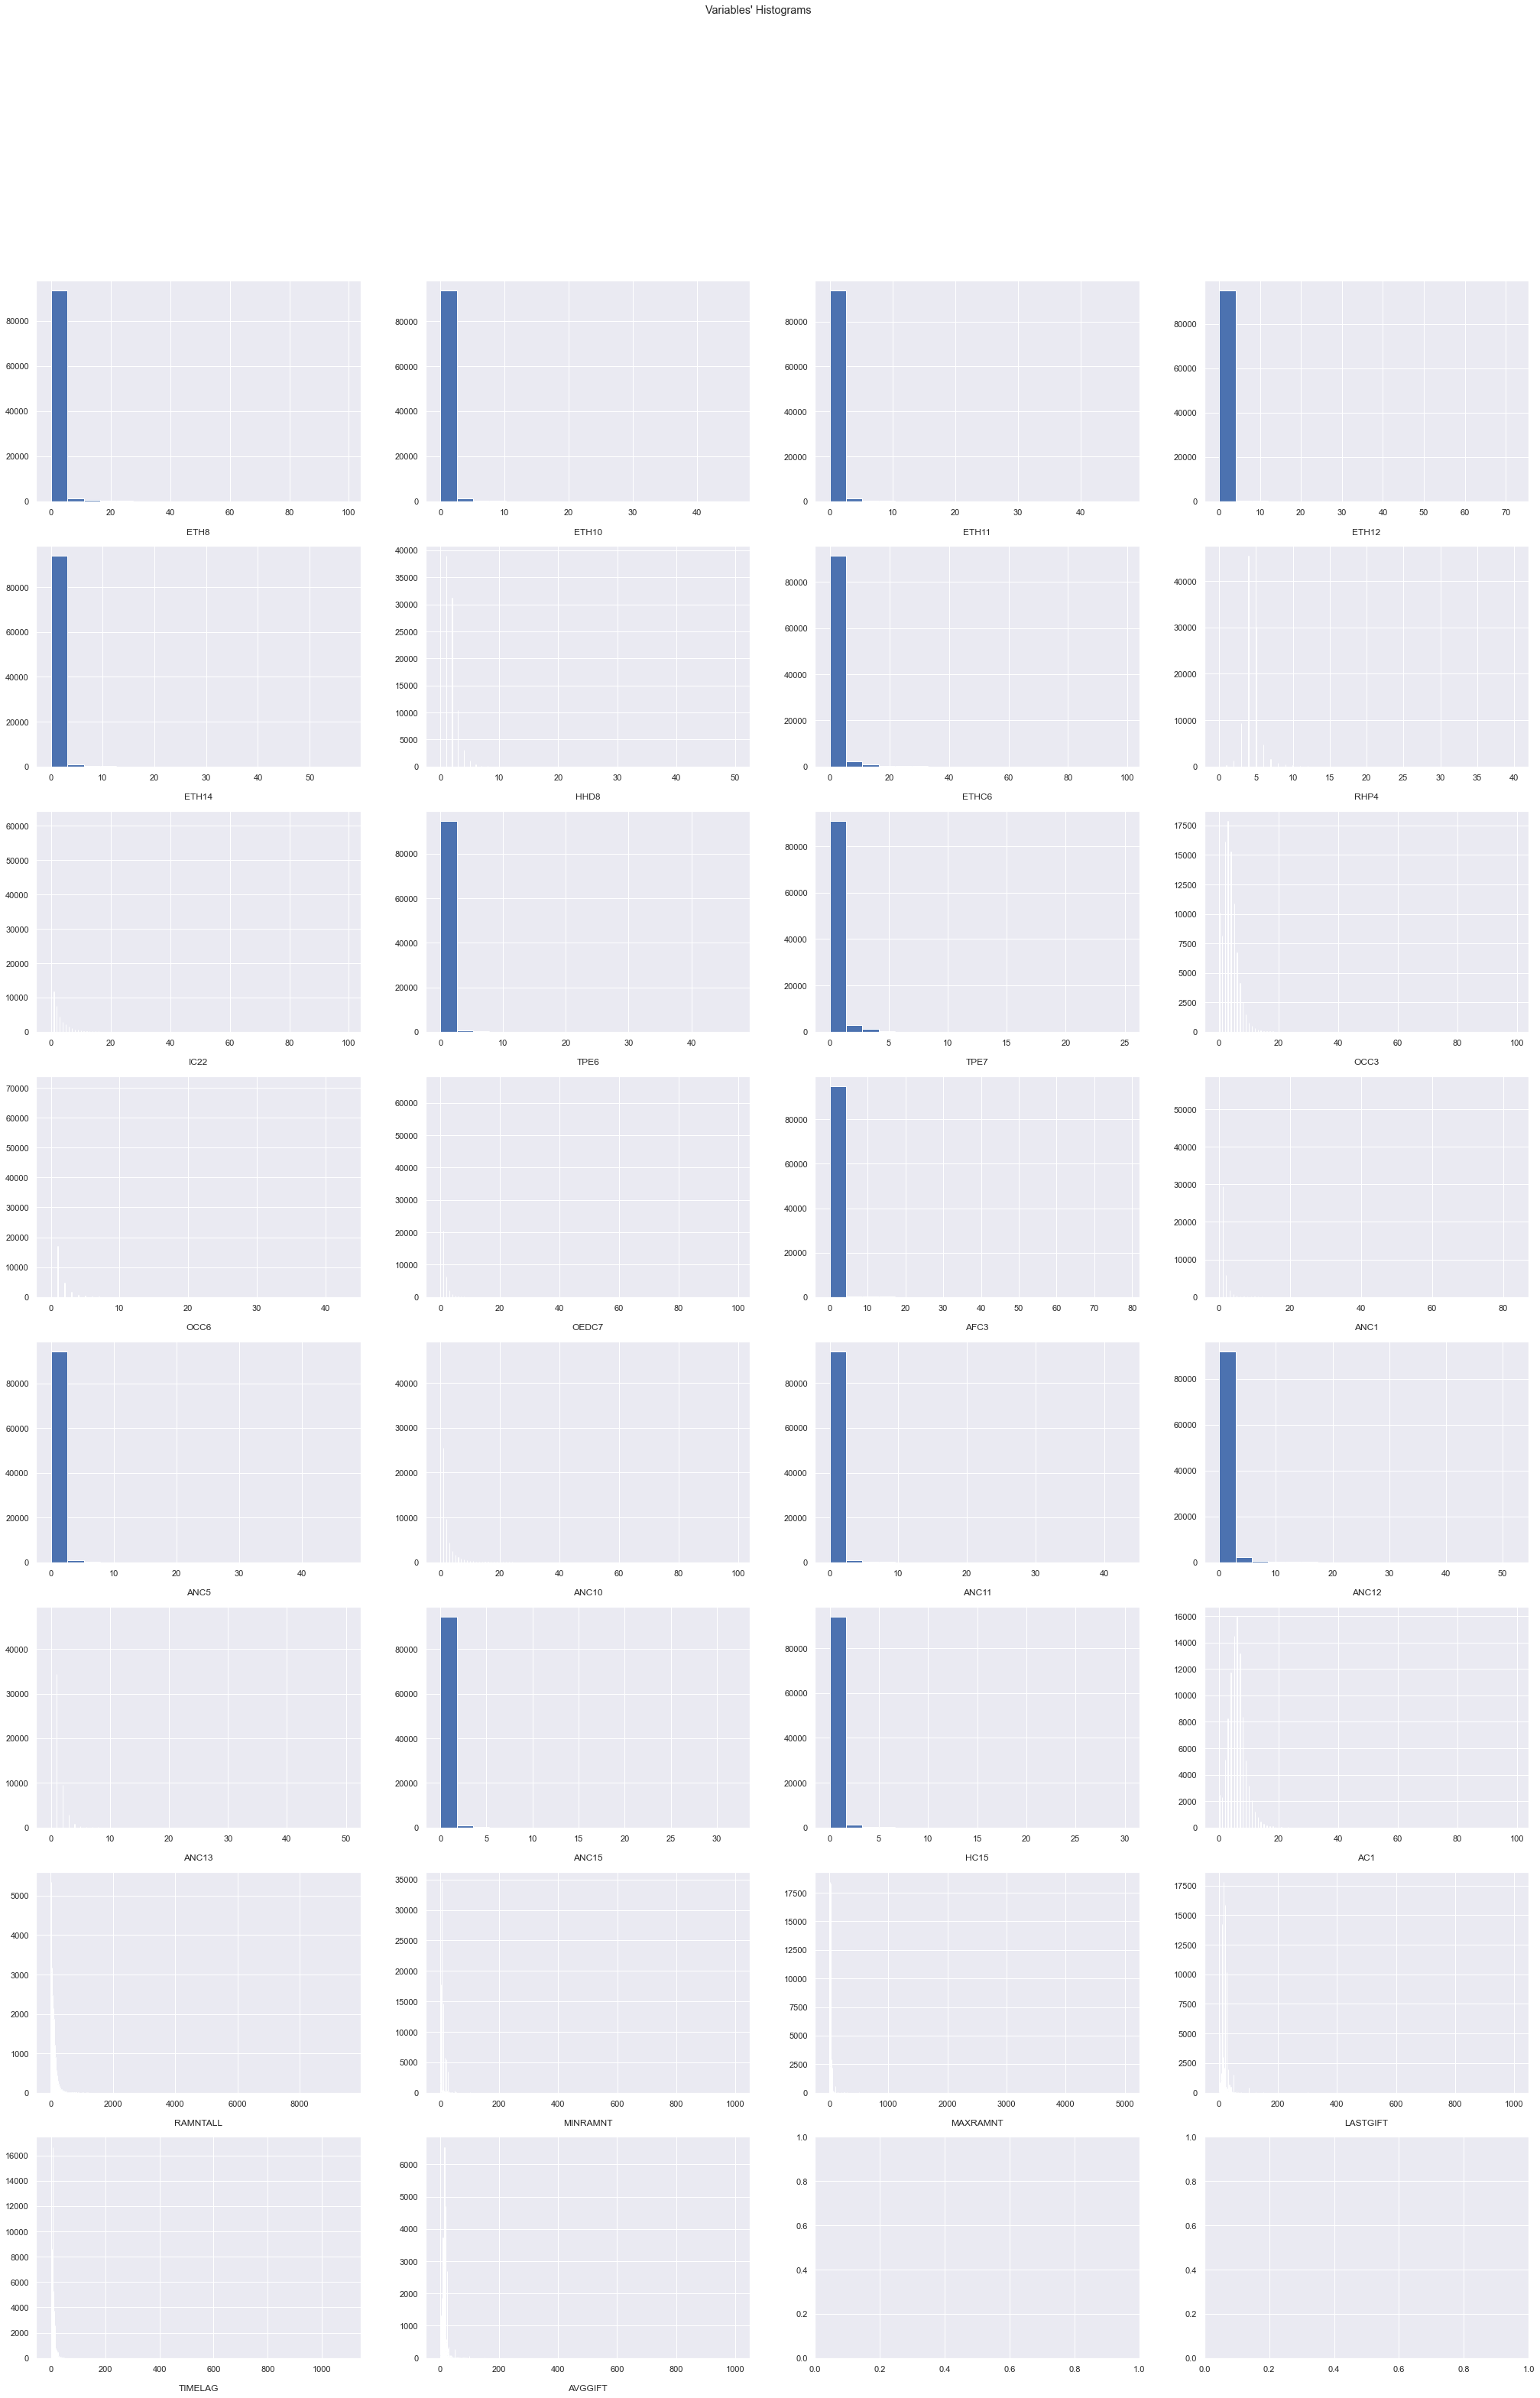

In [18]:
low_variance_features = []
for feature in metric_features:
    if (scaled[feature].var())<0.0009:
        low_variance_features.append(feature)

print('The following are redundant variables because of their low variance:\n',low_variance_features)

#Plotting an histogram of those variables:
histograms(df,low_variance_features, bins='auto',figsize=(35, 50))

# Dropping (note: I wont drop the boolean variable HPHONE_D because it only takes 0 and 1 values so it will easily have a std 
# value above my threshold, but I won´t consider it has being redundant):
df.drop(columns=low_variance_features, inplace=True)

#updating metric features list:
metric_features = update_metric_feat(df)[0]



In [19]:
display(pd.DataFrame(scaled[metric_features].var(), columns=['Variance']).sort_values(by='Variance'))

,Variance
OCC13,0.000906
HUPA7,0.000932
ETH6,0.000953
TPE5,0.000958
ETH7,0.000961
...,...
HVP3,0.137010
HVP4,0.137761
POP90C3,0.163558
LFC9,0.204056


## Correlation
Remove the features that have high correlation values (threshold of 80%) -> To avoid multicolinearity

For each pair of correlated features, our method identifies one of the features for removal (because we only need to remove one of them)

Make visualization with the high correlations (ex:heatmap that shows all the features that have at least one correlation above the threshold)

Make list of correlated features that will be removed, or show the highly correlated pairs of features in a dataframe

Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have high correlation, we can drop one of the two features

#### -> Function that plots an heatmap of the correlation matrix passed as input

In [20]:
def corr_heatmap(corr):    
    # Prepare figure
    fig = plt.figure(figsize=(50, 30))
    # Build annotation matrix (values above |0.8| will appear annotated in the plot)
    mask_annot = np.absolute(corr.values) >= 0.8
    annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))
    # Plot heatmap of the correlation matrix
    sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
                fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, annot_kws={"size": 10})
    # Layout
    fig.subplots_adjust(top=0.95)
    fig.suptitle("Correlation Matrix", fontsize=20)
    plt.show()

#### -> Handling with highly correlated Features:

The features to be removed because of their high correlation are:
 ['POP902', 'POP903', 'ETH13', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906', 'AGEC6', 'CHILC1', 'CHILC3', 'HHAGE1', 'HHAGE2', 'HHAGE3', 'HHN3', 'HHN4', 'HHN5', 'HHN6', 'MARR3', 'HHP1', 'HHP2', 'DW2', 'DW5', 'DW6', 'HV2', 'HV4', 'HU2', 'HHD1', 'HHD2', 'HHD3', 'HHD4', 'HHD5', 'HHD6', 'HHD9', 'HHD11', 'ETHC2', 'ETHC3', 'ETHC4', 'ETHC5', 'HVP1', 'HVP2', 'HVP3', 'HVP4', 'HVP5', 'HVP6', 'RHP1', 'RHP2', 'RHP3', 'HUPA2', 'HUPA5', 'HUPA6', 'RP1', 'RP2', 'RP3', 'RP4', 'IC2', 'IC3', 'IC4', 'IC5', 'IC11', 'IC14', 'IC15', 'IC16', 'IC17', 'IC18', 'IC19', 'IC20', 'IC21', 'IC23', 'HHAS1', 'HHAS4', 'MC2', 'TPE4', 'LFC2', 'LFC3', 'LFC4', 'LFC5', 'EIC1', 'OEDC1', 'OEDC2', 'OEDC3', 'SEC4', 'AFC2', 'AFC5', 'LSC2', 'LSC3', 'VOC2', 'VOC3', 'HC5', 'HC6', 'HC7', 'HC8', 'HC18', 'HC21', 'NUMPROM', 'CARDGIFT']


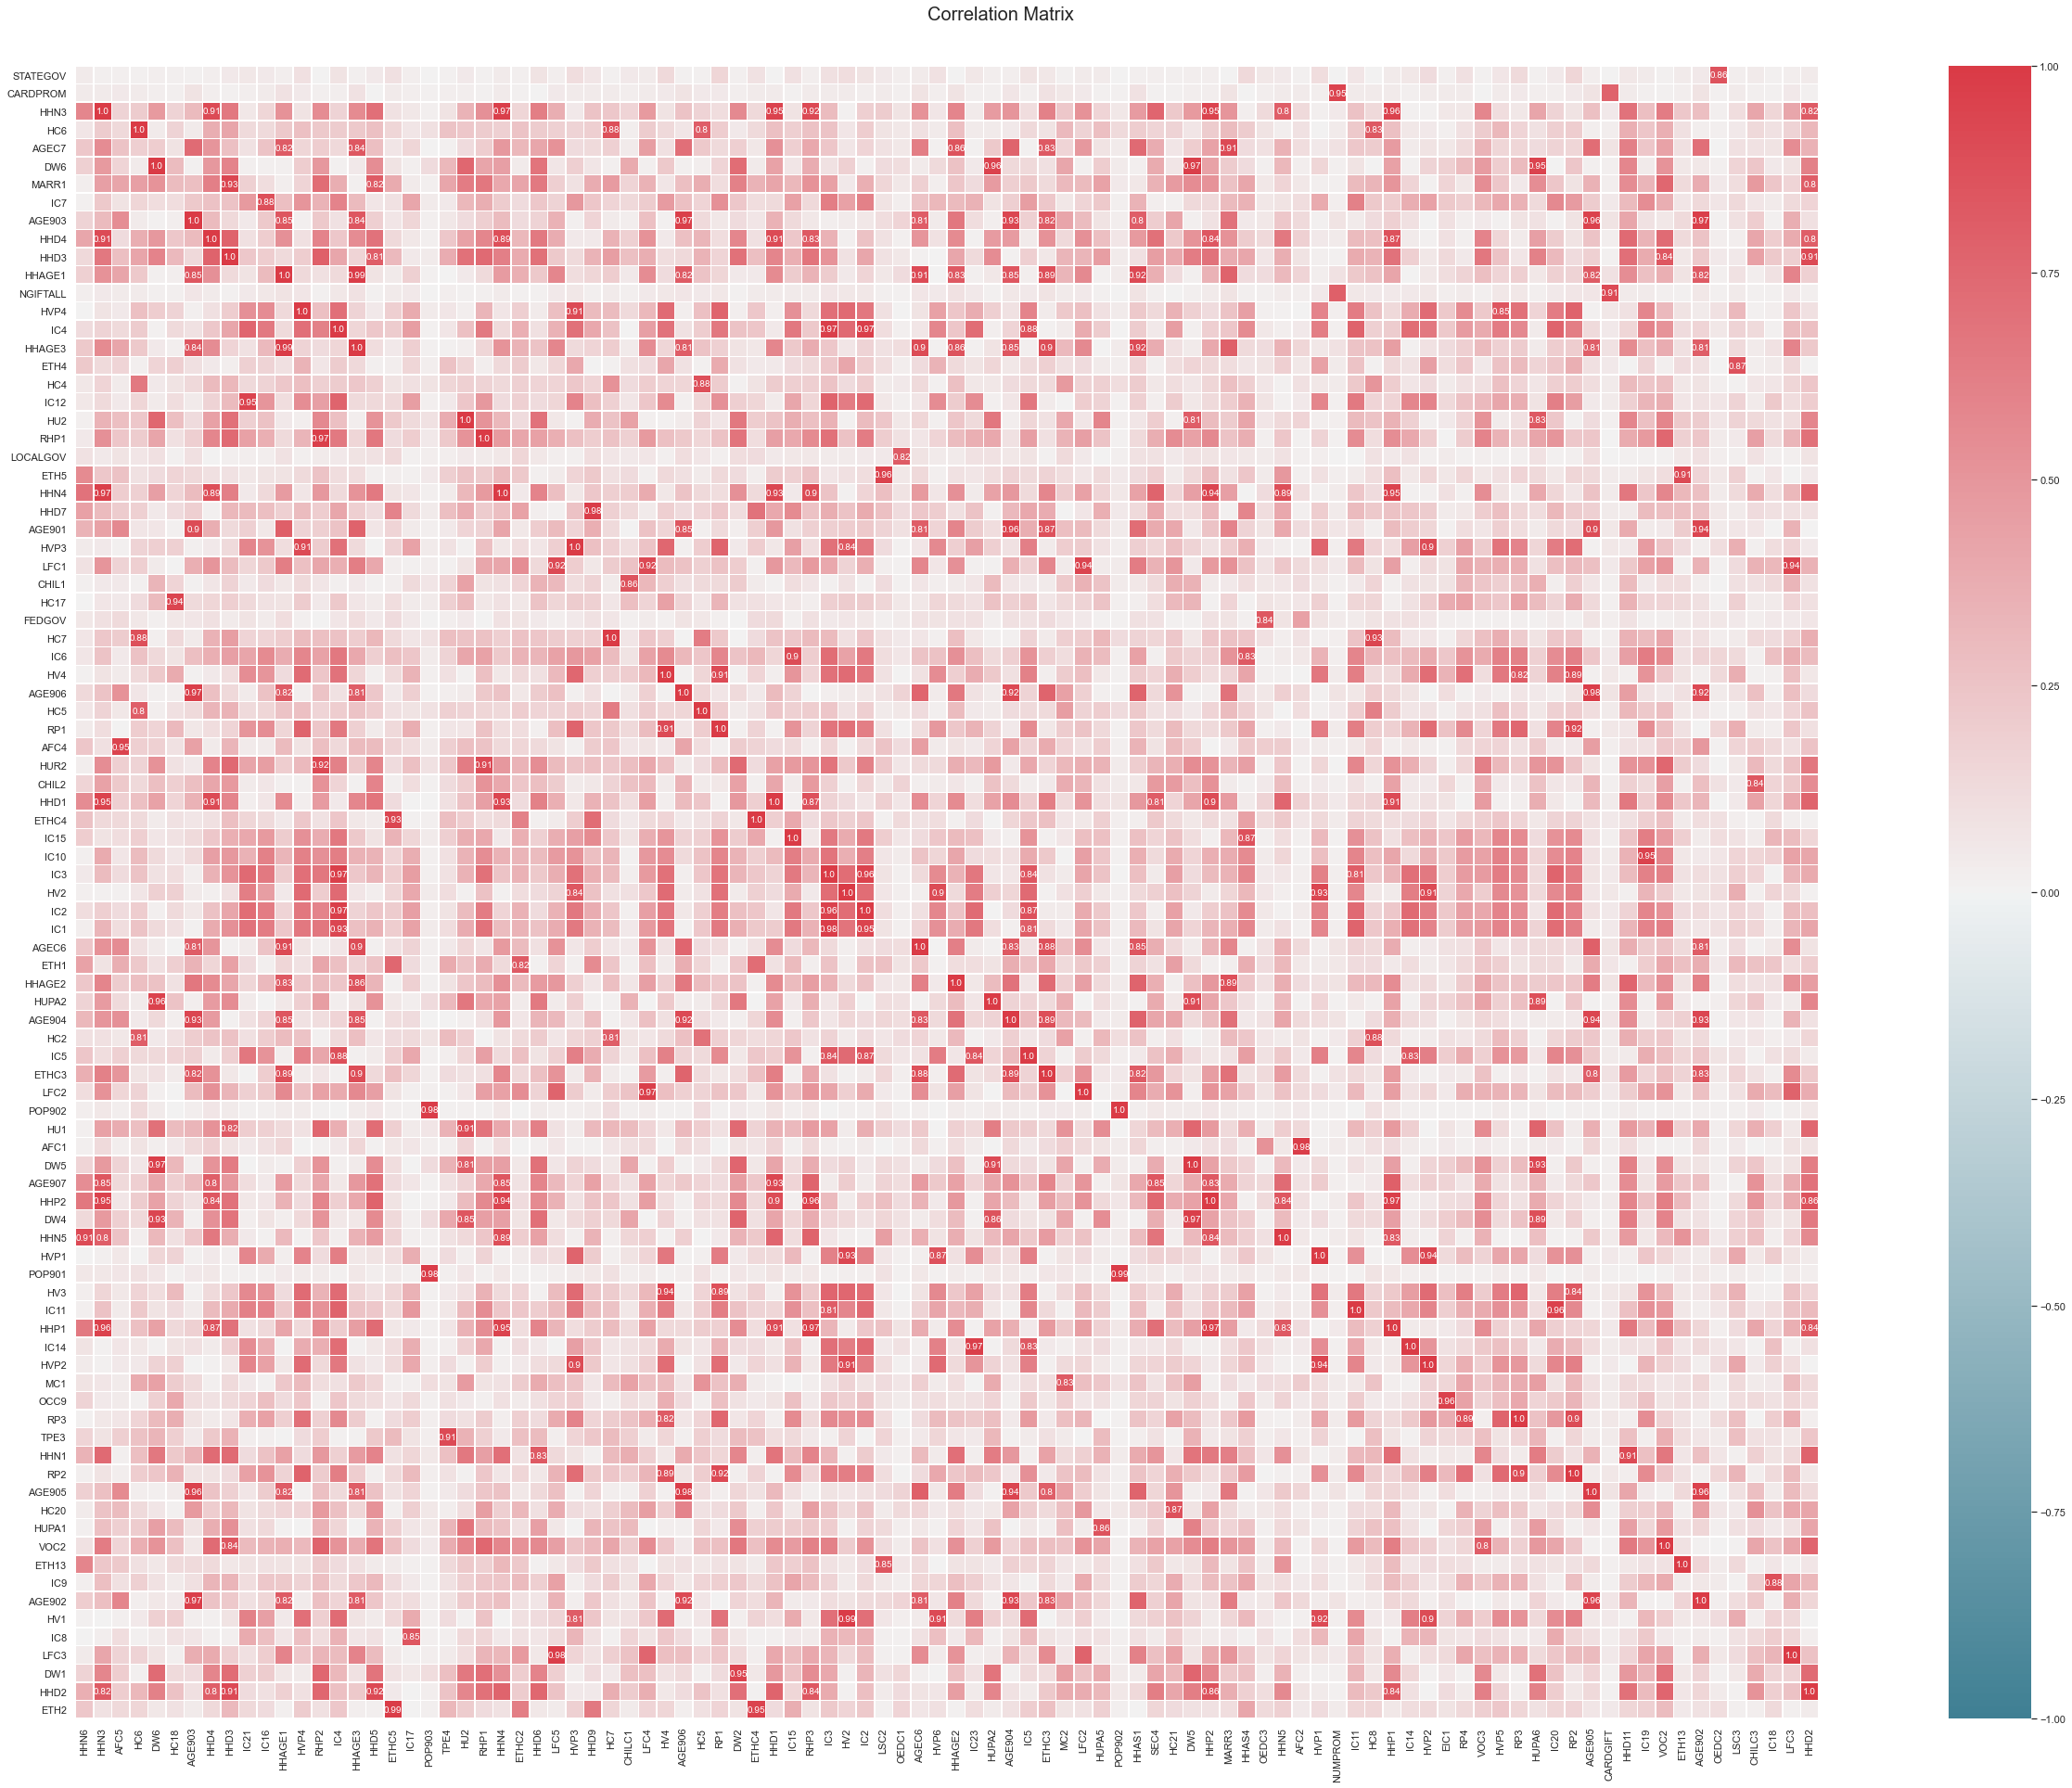

In [21]:
# Creating correlation matrix with the absolute values of the corr:
corr = df.corr().abs()

# Selecting upper triangle of the correlation matrix:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Finding the index of the feature's columns with correlation greater than 0.80 (>=very strong correlation)
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

print('The features to be removed because of their high correlation are:\n',to_drop)

# Saving the pairs of correlated features so I can plot an heatmap of their correlations:

# I´ll save both the dropped feature and the one that was correlated with it:
records = pd.DataFrame(columns = ['dropped_feat', 'corr_feat'])
for column in to_drop:
    corr_features = list(upper.index[upper[column].abs() > 0.8])
    drop_features = [column for _ in range(len(corr_features))]
    # Record the information (need a temp df for now)
    aux_df = pd.DataFrame.from_dict({'dropped_feat': drop_features,'corr_feat': corr_features})

    # Add to dataframe
    records = records.append(aux_df, ignore_index = True)


corr_matrix_plot = corr.loc[list(set(records['corr_feat'])),list(set(records['dropped_feat']))]
title = "Correlations Above Threshold"
# * the features on the x axis are the ones that are going to be removed


# Plotting an heatmap:
corr_heatmap(np.round(corr_matrix_plot,decimals=2))


# Dropping the highly correlated features 
df.drop(columns = to_drop, inplace=True)

# updating metric features list:
metric_features = update_metric_feat(df)[0]

#### Some explanations

[Handle with variables of central tendency measures]

Once there are variables that provide the same information but in different measures, we decide to keep the variables that refer to the median because it's less sensitive to outliers and remove the others ones in these specific cases.

One example of the situation described above is the variable HHP1 (Median Person Per Household) and HHP2 (Average Person Per Household).


[Handle with redundant variables]

Since there are variables that have repeated information, that is, variables that englobe other variables, let's take into consideration, for example, HHN3 (Percent 3 or More Person Households) and HHN4 (Percent 4 or More Person Households). We can soon conclude that HHN4 is mentioned in HHN3, once 'more than 3' englobe the percent of 4 and so on.

In these particular cases, we decide to keep the variables that provide the same meaning as the others of the same kind, without losing information, and discard the ones that are already indirectly specified in the ones that we chose to keep.

#### -> PCA

# Categorical Features

#### -> Pieplots

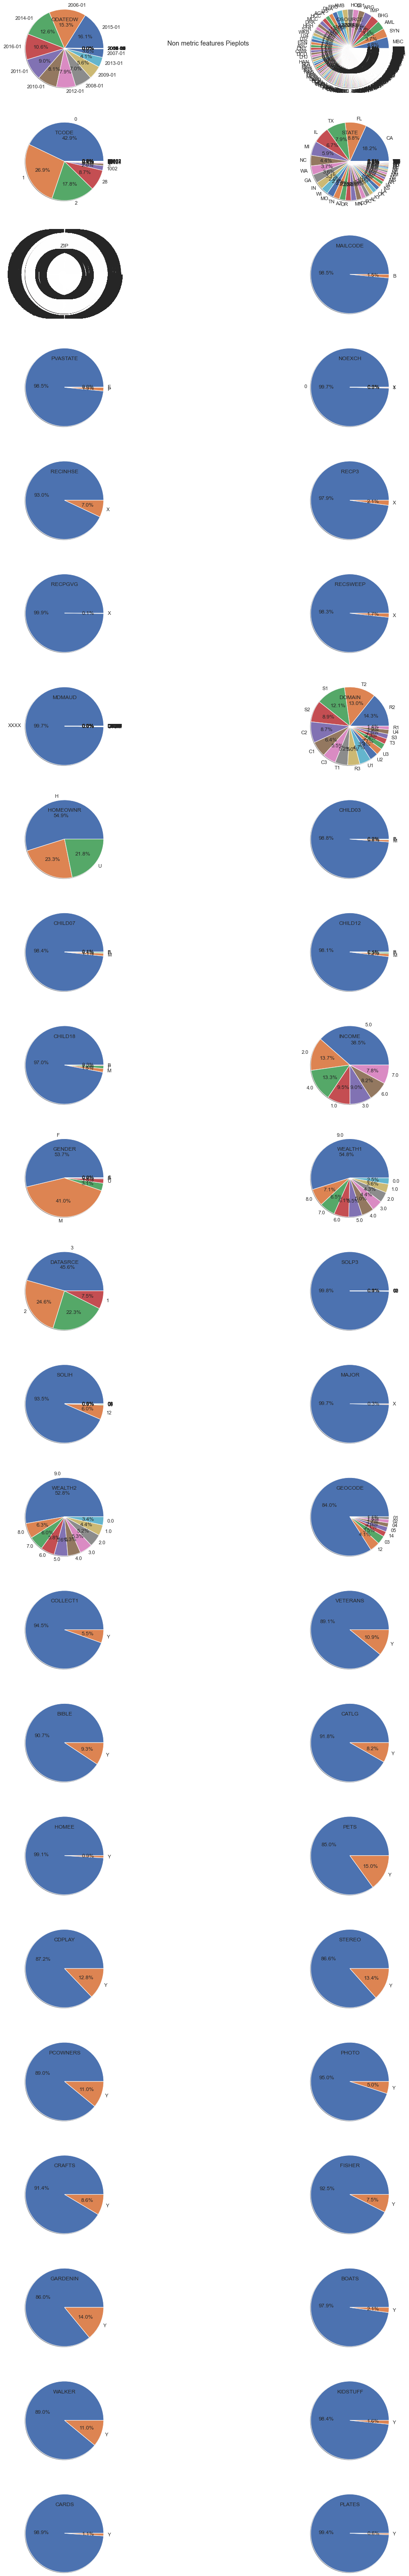

In [22]:
# import plotly.express as px
# from plotly.subplots import make_subplots

# # Prepare figure. Create figures where each pieplot will be placed
# # use 'domain' type for Pie subplot
# for feat in non_metric_features:
#     fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
#     fig=px.pie(df[feat], names=feat, title=feat)
#     fig.show()

sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(23, 2, figsize=(20, 80))

# Plot data
# Iterate across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    ax.pie(df[feat].value_counts().values,labels=df[feat].value_counts().index,autopct='%1.1f%%', shadow=True, radius=2)
    ax.set_title(feat)
fig.tight_layout()
# Layout
# Add a centered title to the figure:
title = " Non metric features Pieplots"
plt.suptitle(title)
plt.show()

#### -> Single Value Features

In [25]:
# get number of unique values for each column using numpy
counts = list(df.nunique())
names = list(df.nunique().index)

def create_dict(keys, values): 
    return dict(zip(keys, values + [None] * (len(keys) - len(values))))
columns = create_dict(names, counts)

# record columns to delete
to_del = dict((k, v) for k, v in columns.items() if v == 1) 
to_del

{'ADATE_5': 1, 'RFA_2R': 1}

#### -> Remove the variables that for one category have more than 90% of the observations:

In [26]:
to_drop=[]
for feature in non_metric_features:
    for proportion in df[feature].value_counts()/len(df):
        if proportion > 0.90:
            to_drop.append(feature)
            break

print('The non metric features that have more than 90% in one of their categories/unique values (to be dropped because \
of their redundancy) are the following:\n',to_drop)

df.drop(columns=to_drop, inplace=True)

# updating non metric features list:
non_metric_features = update_metric_feat(df)[1]

The non metric features that have more than 90% in one of their categories/unique values (to be dropped because of their redundancy) are the following:
 ['MAILCODE', 'PVASTATE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP', 'MDMAUD', 'CHILD03', 'CHILD07', 'CHILD12', 'CHILD18', 'SOLP3', 'SOLIH', 'MAJOR', 'COLLECT1', 'BIBLE', 'CATLG', 'HOMEE', 'PHOTO', 'CRAFTS', 'FISHER', 'BOATS', 'KIDSTUFF', 'CARDS', 'PLATES', 'ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7', 'ADATE_8', 'ADATE_9', 'ADATE_10', 'ADATE_13', 'ADATE_14', 'ADATE_16', 'ADATE_17', 'ADATE_19', 'ADATE_21', 'ADATE_22', 'ADATE_24', 'MAXADATE', 'RFA_2R', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A']


#### ->Drop the categorical features with high variability , in case none of its categories have more than 10%:

In [27]:
to_drop=[]
for feature in non_metric_features:
    aux =[]
    for proportion in df[feature].value_counts()/len(df):
        if proportion < 0.10:
            aux.append(proportion)
    if len(aux)==len(df[feature].value_counts()): # if all categories have less than 10%;
        to_drop.append(feature)

print('The non metric features that have less than 10% in all of their categories/unique values (to be dropped because \
of their redundancy) are the following:\n',to_drop)

df.drop(columns=to_drop, inplace=True)

# updating non metric features list:
non_metric_features = update_metric_feat(df)[1]

The non metric features that have less than 10% in all of their categories/unique values (to be dropped because of their redundancy) are the following:
 ['OSOURCE', 'ZIP', 'MINRDATE', 'FISTDATE']
